# A neural network for text auto-completion

## Libs

In [1]:
from transformers import BertTokenizerFast

import numpy as np

from pathlib import Path

import random
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

from tqdm import tqdm

from typing import List

from src.data_utils import (read_file, 
                            preprocessing_text, 
                            plot_length_hist,
                            print_size)

from src.next_token_dataset import TweetRNNDataset

from src.lstm_model import PredictorModel

from src.train_lstm import train_lstm_model
from src.eval_lstm import plot_metrics

from src.eval_transformer_pipeline import evaluate_transformer_model_rouge

random.seed(42)
torch.manual_seed(42)

/home/ubuntu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data collection and preparation

In [2]:
project_dir_path:str = Path(__name__).parent.resolve()
print("Root dir: ",  project_dir_path)

data_catalog_name:str = "data"
raw_dataset_name:str = "tweets.txt"

raw_dataset_path:str = str(project_dir_path / Path(data_catalog_name)/ Path(raw_dataset_name))
print("Raw dataset path: ", raw_dataset_path)

Root dir:  /home/ubuntu/text_autocomplete
Raw dataset path:  /home/ubuntu/text_autocomplete/data/tweets.txt


In [3]:
raw_tweets = read_file(raw_dataset_path)

print("DATASET'S LENGTH:" , len(raw_tweets))
print()
print("EXAMPLE TEXTS: ")
print("\n\n" + "\n\n".join(raw_tweets[:10]))

1600498it [00:00, 2712469.92it/s]

DATASET'S LENGTH: 1600498

EXAMPLE TEXTS: 


@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds


my whole body feels itchy and like its on fire 


@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 


@Kwesidei not the whole crew 


Need a hug 


@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?


@Tatiana_K nope they didn't have it 


@twittera que me muera ? 



In [4]:
%%time
clear_tweets = list(map(preprocessing_text, raw_tweets))

print("EXAMPLE CLEAR TEXTS: ")
print("\n\n" + "\n\n".join(clear_tweets[:10]))

EXAMPLE CLEAR TEXTS: 


switchfoot com2y1zl awww thats a bummer you shoulda got david carr of third day to do it d

is upset that he cant update his facebook by texting it and might cry as a result school today also blah

kenichan i dived many times for the ball managed to save 50 the rest go out of bounds

my whole body feels itchy and like its on fire

nationwideclass no its not behaving at all im mad why am i here because i cant see you all over there

kwesidei not the whole crew

need a hug

loltrish hey long time no see yes rains a bit only a bit lol im fine thanks hows you

tatianak nope they didnt have it

twittera que me muera
CPU times: user 13.1 s, sys: 64.4 ms, total: 13.2 s
Wall time: 13.2 s


In [5]:
train_tweets, val_and_test_tweets = train_test_split(clear_tweets, test_size=0.2, random_state=42)
val_tweets, test_tweets = train_test_split(val_and_test_tweets, test_size=0.5, random_state=42)

print("TRAIN SIZE: ", len(train_tweets))
print("VAL SIZE: ", len(val_tweets))
print("TEST SIZE: ", len(test_tweets))


TRAIN SIZE:  1280398
VAL SIZE:  160050
TEST SIZE:  160050


First quantile:  39.0
Third quantile  96.0


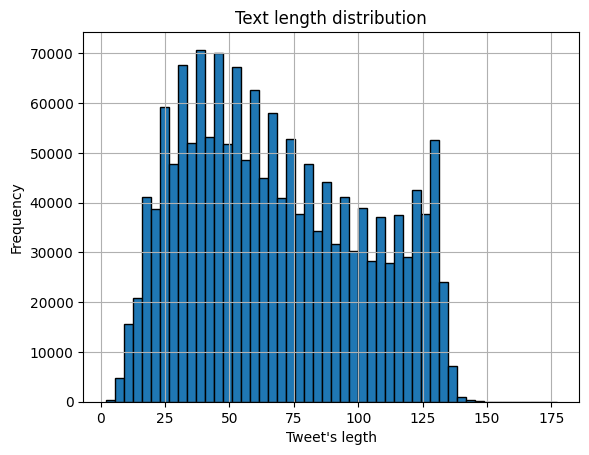

In [6]:
texts_legth: List[int] = [len(text) for text in clear_tweets]

print("First quantile: ", np.quantile(texts_legth, 0.25))
print("Third quantile ", np.quantile(texts_legth, 0.75) )
plot_length_hist(texts_legth)

In [7]:
del raw_tweets, clear_tweets, texts_legth, read_file, preprocessing_text, plot_length_hist

## MAKE DATASET

In [8]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [9]:
train_dataset = TweetRNNDataset(train_tweets, tokenizer, seq_len=32)
val_dataset = TweetRNNDataset(val_tweets, tokenizer, seq_len=32)

In [10]:
print_size(train_dataset, data_name="train")

TRAIN DATASET
X:  tensor([21025, 13344,  3122, 25212,  2361,  1045,  9471,  1048,  2863,  2080,
         1045,  2876,  2102,  2022,  2583,  2000,  4312,  2288,  2019, 11360,
         4826,  2036,  2123,  2102,  2017, 17704,  2342,  1037,  3153,  4256,
         2003, 10459])
Y:  tensor(2099)
X SHAPE:  torch.Size([32])
Y SHAPE:  torch.Size([])


In [11]:
del train_tweets, val_tweets

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_tweets,batch_size=256, shuffle=False)

In [13]:
print_size(train_dataloader, data_name="TRAIN", type="dataloader")

TRAIN DATALOADER
BATCH X SHAPE: torch.Size([256, 32])
BATCH Y SHAPE: torch.Size([256])
BATCH X OBJECT:  tensor([ 7361,  4523,  2015,  6203, 15390,  3240, 16147,  2683,  2487,  1045,
         2626,  2115,  5796,  2078,  2006,  1037, 22555,  2609,  2012,  2560,
         2017,  2097,  2022,  4531, 17111,  2080,  2116,  2047, 20833,  2031,
         4569,  2210])
BATCH Y OBJECT:  tensor(15453)


In [14]:
del print_size, train_dataset, val_dataset

## LSTM MODEL

### Make Model

In [15]:
vocab_size = tokenizer.vocab_size
hidden_dim = 256
criterion = nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"

model_lstm = PredictorModel(vocab_size, hidden_dim=hidden_dim, rnn_type="LSTM")
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.002)

model_gru = PredictorModel(vocab_size, hidden_dim=hidden_dim, rnn_type="GRU")
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.002)

In [16]:
device

'cuda'

### TRAIN MODEL

In [17]:
metrics_history_lstm = train_lstm_model(
    train_dataloader,
    val_dataloader,
    test_dataloader,
    tokenizer,
    model_lstm,
    optimizer_lstm,
    criterion,
    n_epochs=5,
    device=device,
)

 20%|██        | 1/5 [06:32<26:09, 392.36s/it]

------------------------------ EPOOCH: 1 ------------------------------
TRAIN LOSS: 6.6663932365864325 | VAL LOSS: 6.05845176127919 | VAL ACCURACY: 0.16514391701586864
VAL ROUGE: rouge1: 0.0526 rouge2: 0.0032 rougeL: 0.0520 rougeLsum: 0.0520

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|##s i cant get it
ORIGINAL|GENERATED: it on for two freaking days|it in the way lol
ORIGINAL|GENERATED: from brace oh well tweet me|i cant get it in the way
ORIGINAL|GENERATED: think im getting sick|cant get it
ORIGINAL|GENERATED: time nighty nighty people|week to go to me up
----------------------------------------


 40%|████      | 2/5 [13:05<19:38, 392.97s/it]

------------------------------ EPOOCH: 2 ------------------------------
TRAIN LOSS: 5.466568857883941 | VAL LOSS: 5.834305796706886 | VAL ACCURACY: 0.1860273407982414
VAL ROUGE: rouge1: 0.0538 rouge2: 0.0046 rougeL: 0.0533 rougeLsum: 0.0533

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|##s i cant wait to
ORIGINAL|GENERATED: it on for two freaking days|it in a good day x
ORIGINAL|GENERATED: from brace oh well tweet me|##s i love it is a good day
ORIGINAL|GENERATED: think im getting sick|cant wait to
ORIGINAL|GENERATED: time nighty nighty people|time to do it in a
----------------------------------------


 60%|██████    | 3/5 [19:41<13:08, 394.29s/it]

------------------------------ EPOOCH: 3 ------------------------------
TRAIN LOSS: 4.671984374652457 | VAL LOSS: 5.853257329840409 | VAL ACCURACY: 0.19289688809507455
VAL ROUGE: rouge1: 0.0522 rouge2: 0.0045 rougeL: 0.0516 rougeLsum: 0.0517

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|##s me sad xoxo
ORIGINAL|GENERATED: it on for two freaking days|it in a while ago of
ORIGINAL|GENERATED: from brace oh well tweet me|xd xd i cant wait
ORIGINAL|GENERATED: think im getting sick|cant sleep well
ORIGINAL|GENERATED: time nighty nighty people|time to do it all day
----------------------------------------


 80%|████████  | 4/5 [26:17<06:34, 394.73s/it]

------------------------------ EPOOCH: 4 ------------------------------
TRAIN LOSS: 3.899105849855634 | VAL LOSS: 5.990451444659317 | VAL ACCURACY: 0.19392732018959952
VAL ROUGE: rouge1: 0.0508 rouge2: 0.0046 rougeL: 0.0503 rougeLsum: 0.0503

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|##s me up lol xx
ORIGINAL|GENERATED: it on for two freaking days|it on my phone so i
ORIGINAL|GENERATED: from brace oh well tweet me|xd xoxo lt3 lt
ORIGINAL|GENERATED: think im getting sick|cant sleep well
ORIGINAL|GENERATED: time nighty nighty people|time to do it on my
----------------------------------------


100%|██████████| 5/5 [32:50<00:00, 394.03s/it]

------------------------------ EPOOCH: 5 ------------------------------
TRAIN LOSS: 3.1954398284506644 | VAL LOSS: 6.187738242902253 | VAL ACCURACY: 0.19145428316273957
VAL ROUGE: rouge1: 0.0482 rouge2: 0.0041 rougeL: 0.0477 rougeLsum: 0.0477

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|##s me sad i love you
ORIGINAL|GENERATED: it on for two freaking days|this news for you all x
ORIGINAL|GENERATED: from brace oh well tweet me|nite nite nite nite
ORIGINAL|GENERATED: think im getting sick|cant go to
ORIGINAL|GENERATED: time nighty nighty people|time to do it again soon
----------------------------------------


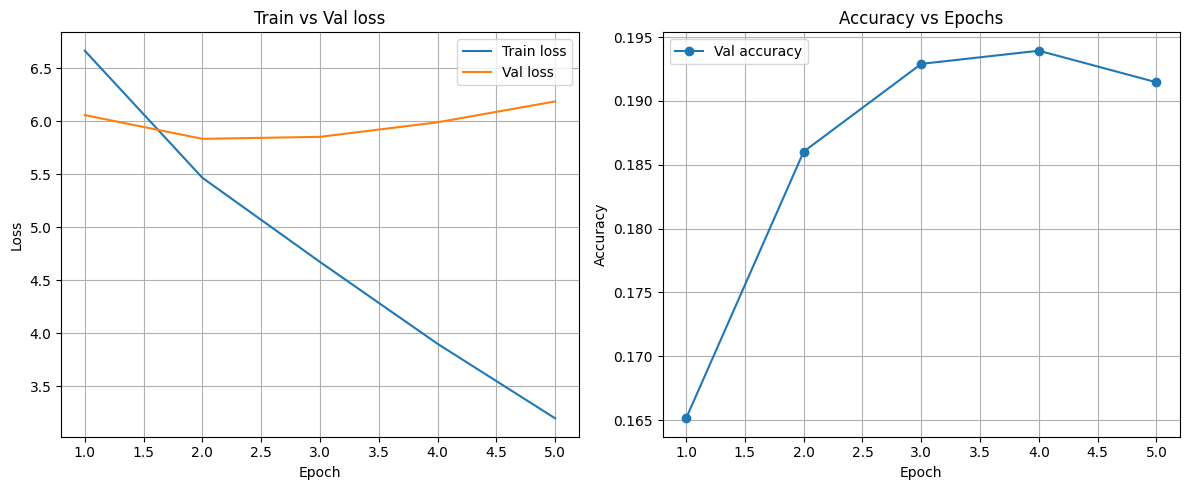

In [18]:
plot_metrics(metrics_history_lstm)

In [19]:
del optimizer_lstm, model_lstm , metrics_history_lstm

In [20]:
metrics_history_gru = train_lstm_model(
    train_dataloader,
    val_dataloader,
    test_dataloader,
    tokenizer,
    model_gru,
    optimizer_gru,
    criterion,
    n_epochs=5,
    device=device,
)

 20%|██        | 1/5 [06:22<25:28, 382.00s/it]

------------------------------ EPOOCH: 1 ------------------------------
TRAIN LOSS: 6.5274313215061275 | VAL LOSS: 5.942996644137199 | VAL ACCURACY: 0.17455519681253007
VAL ROUGE: rouge1: 0.0475 rouge2: 0.0033 rougeL: 0.0469 rougeLsum: 0.0469

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|##s i could be like it
ORIGINAL|GENERATED: it on for two freaking days|it up to do it up
ORIGINAL|GENERATED: from brace oh well tweet me|##s in the worlds lol xx
ORIGINAL|GENERATED: think im getting sick|could be there to
ORIGINAL|GENERATED: time nighty nighty people|is a lot of my life
----------------------------------------


 40%|████      | 2/5 [12:40<18:59, 379.74s/it]

------------------------------ EPOOCH: 2 ------------------------------
TRAIN LOSS: 5.166075149999523 | VAL LOSS: 5.841574970044587 | VAL ACCURACY: 0.18815690046025968
VAL ROUGE: rouge1: 0.0478 rouge2: 0.0035 rougeL: 0.0473 rougeLsum: 0.0473

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|##s i was like thats
ORIGINAL|GENERATED: it on for two freaking days|it all day xoxo
ORIGINAL|GENERATED: from brace oh well tweet me|##s xo xo xo x
ORIGINAL|GENERATED: think im getting sick|miss you all day
ORIGINAL|GENERATED: time nighty nighty people|is a great day lol
----------------------------------------


 60%|██████    | 3/5 [18:57<12:37, 378.62s/it]

------------------------------ EPOOCH: 3 ------------------------------
TRAIN LOSS: 4.214420628909692 | VAL LOSS: 5.978662064200954 | VAL ACCURACY: 0.19131689221680293
VAL ROUGE: rouge1: 0.0489 rouge2: 0.0036 rougeL: 0.0484 rougeLsum: 0.0484

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|i want to be there for
ORIGINAL|GENERATED: it on for two freaking days|it all day ahead of me
ORIGINAL|GENERATED: from brace oh well tweet me|to do it now though xxxxxx
ORIGINAL|GENERATED: think im getting sick|love you xxx
ORIGINAL|GENERATED: time nighty nighty people|is good though i miss him
----------------------------------------


 80%|████████  | 4/5 [25:18<06:19, 379.53s/it]

------------------------------ EPOOCH: 4 ------------------------------
TRAIN LOSS: 3.325438749247156 | VAL LOSS: 6.221612570578592 | VAL ACCURACY: 0.18657690458198806
VAL ROUGE: rouge1: 0.0424 rouge2: 0.0030 rougeL: 0.0420 rougeLsum: 0.0420

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|i want to attends with him
ORIGINAL|GENERATED: it on for two freaking days|to go with it all night
ORIGINAL|GENERATED: from brace oh well tweet me|xxx especially xxx especially xxx
ORIGINAL|GENERATED: think im getting sick|dont know why
ORIGINAL|GENERATED: time nighty nighty people|year lol no more day
----------------------------------------


100%|██████████| 5/5 [31:37<00:00, 379.46s/it]

------------------------------ EPOOCH: 5 ------------------------------
TRAIN LOSS: 2.5825794120672727 | VAL LOSS: 6.500909863856801 | VAL ACCURACY: 0.1842412585010648
VAL ROUGE: rouge1: 0.0403 rouge2: 0.0027 rougeL: 0.0399 rougeLsum: 0.0399

EXAMPLES:
ORIGINAL|GENERATED: is really disheartening|i think so i do it
ORIGINAL|GENERATED: it on for two freaking days|my teeth lol xd
ORIGINAL|GENERATED: from brace oh well tweet me|to me please hahaha kiddingk
ORIGINAL|GENERATED: think im getting sick|know gross so much
ORIGINAL|GENERATED: time nighty nighty people|morn me so i can
----------------------------------------


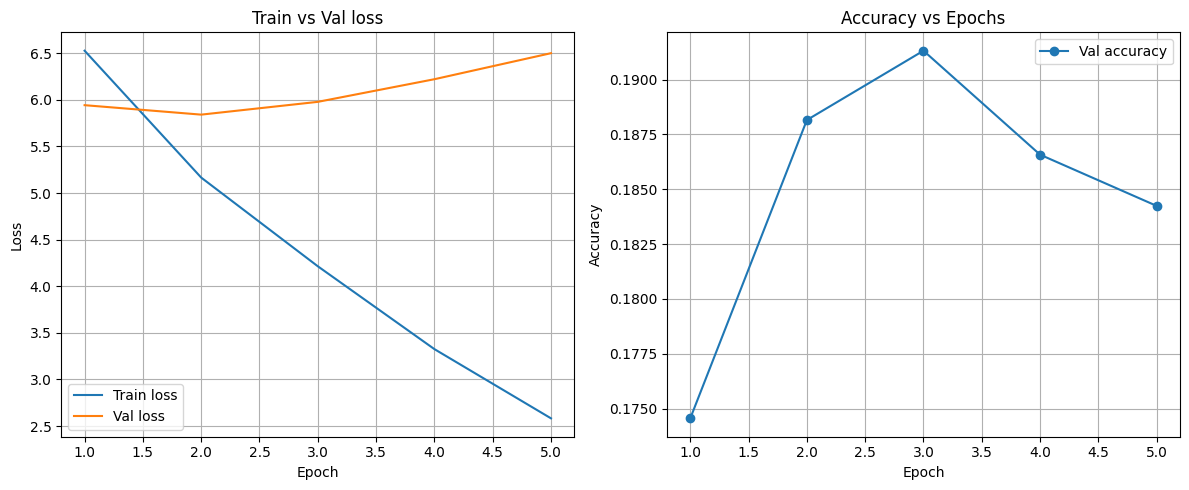

In [21]:
plot_metrics(metrics_history_gru)

In [22]:
del model_gru, optimizer_gru, metrics_history_gru

In [23]:
del criterion, tokenizer, vocab_size, train_dataloader, val_dataloader, plot_metrics

## TRANSFORMER MODEL

### MAKE MODEL

In [24]:
device = 0 if torch.cuda.is_available() else -1

In [25]:
model_transformer_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_transformer_name)
model = AutoModelForCausalLM.from_pretrained(model_transformer_name)

model.config.pad_token_id = model.config.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [26]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    device=device
)

Device set to use cuda:0


In [27]:
evaluate_transformer_model_rouge(test_tweets, generator, max_length=130)

100%|██████████| 160050/160050 [41:45<00:00, 63.87it/s] 


------------------------------ RESULT ------------------------------
VAL ROUGE: rouge1: 0.0663 rouge2: 0.0070 rougeL: 0.0655 rougeLsum: 0.0655

EXAMPLES:
ORIGINAL|GENERATED: do that is really disheartening|who are really passionate about
ORIGINAL|GENERATED: it on for two freaking days|it in place again to have
ORIGINAL|GENERATED: ache from brace oh well tweet me|in my face i have not
ORIGINAL|GENERATED: im getting sick|you should start
ORIGINAL|GENERATED: this time nighty nighty people|my bed and start playing
----------------------------------------


In [28]:
del evaluate_transformer_model_rouge, generator, model, tokenizer, test_tweets

## Conclusion

1.	LSTM vs GRU

    •	Best LSTM (epoch 2):

    •	VAL ROUGE-1 ≈ 0.0538, ROUGE-L ≈ 0.0533

    •	VAL ACC ≈ 0.186

    •	Best GRU (epoch 3):

    •	VAL ROUGE-1 ≈ 0.0489, ROUGE-L ≈ 0.0484

    •	VAL ACC ≈ 0.191

2.	RNN vs Transformer

	•	Transformer:
    
	•	ROUGE-1 ≈ 0.0663, ROUGE-L ≈ 0.0655

• From the examples, we can see that the transformer:
 • generates more meaningful endings (“who are really passionate about”, “my bed and start playing”),
 • gets less stuck in repetition and formulaic responses

The transformer provides a significant improvement in ROUGE quality and is the best of the three models based on qualitative examples.

In the experiment, the transformer outperforms both LSTM and GRU in terms of ROUGE and text quality, and LSTM performs slightly better among RNNs. 
Therefore, it is logical to use LSTM as the base RNN model for mobile devices, and the transformer can be used when there are no strict resource constraints.